In [365]:
!pip install wordcloud==1.8.2.2 Pillow==9.0.1

In [ ]:
# Установка antiword для работы с .doc файлами на MacOS Monterey

!export HOMEBREW_NO_AUTO_UPDATE=1
!brew install antiword

In [46]:
import pandas as pd
import numpy as np
import json
import os
import re
import docx
from subprocess import Popen, PIPE

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
import pickle

from PyPDF2 import PdfReader
from striprtf.striprtf import rtf_to_text

import pymorphy2
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

## Инициализация глобальных переменных и определение функций

In [3]:
########################## инициализация глобальных переменных ##########################
toktok = ToktokTokenizer()
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = nltk.corpus.stopwords.words('russian')

# заменить на свой путь
HACK_PATH = '/Users/mayabikmetova/xmas/hacka-aka-embedika' 
DOC_PATH = '/Users/mayabikmetova/xmas/hacka-aka-embedika/docs' 

In [33]:
def text_from_doc(filename):
    p = Popen(['antiword', '-f', '{}'.format(filename)], stdin=PIPE, stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    text = output.decode('utf-8')
    return text

def text_from_docx(filename):
    doc = docx.Document(filename)
    fullText = []  
    for para in doc.paragraphs:
        fullText.append(para.text)    
    return '\n'.join(fullText)


def text_from_pdf(filename):
    reader = PdfReader(filename)
    num_pages = reader.getNumPages()
    text_pages = []
    for i in range(num_pages):
        page = reader.pages[i].extract_text()
        text_pages.append(page)
    return ''.join(text_pages)


def text_from_rtf(filename):
    with open(filename) as f:
        content = f.read()
        return rtf_to_text(content)
    
class FileTypeError(Exception):
    def __init__(self, msg='Неверный тип файла! Допустимые типы: doc, docx, pdf, rtf.'):
        super().__init__(msg)


def extract_text(path):
    """
    Функция для выделения текста из документы. Допустимые типы файлов: doc, docx, pdf, rtf.
    
    Параметры:
        path: Путь к обрабатываемому файлу.
    """
    func_dict = {'doc': text_from_doc, 'docx': text_from_docx, 'pdf': text_from_pdf, 'rtf': text_from_rtf}
    
    try:
        filename = os.path.basename(path)
        extension = filename.split('.')[1]

        print('Обрабатывается файл ', path)

        if extension not in ['doc', 'docx', 'pdf', 'rtf']:
            raise FileTypeError
        else:
            text = func_dict[extension](path)

            return text
    except Exception as e:
        print(e)

In [43]:
def preprocess(line):
    """
    Функция предобработки текста:
    - очищает текст от цифр и лишних знаков препинания,
    - удаляет короткие слова (состоящие из 1 буквы),
    - удаляет стоп-слова,
    - проводит лемматизацию
    """
    char_regex = re.compile(r'[^а-яa-z]')
    line = char_regex.sub(' ', line.lower())
    
    short_words = re.compile(r'\b[а-яa-z]{1}\b')
    line = short_words.sub(' ', line.lower())
    
    tokenized = toktok.tokenize(line)
    lemmatized = []
    for i in tokenized:
        if i not in russian_stopwords:
            lemma = morph.parse(i)[0].normal_form
            lemmatized.append(str(lemma))
    return ' '.join(lemmatized)


def preprocess_no_lemm(line):
    """
    Функция очистки текста без лемматизации.
    """
    char_regex = re.compile(r'[^а-яa-z\s]')
    line = char_regex.sub(' ', line.lower())
    
    short_words = re.compile(r'\b[а-яa-z]{1}\b')
    line = short_words.sub(' ', line.lower())
    
    return line.strip()

## Формируем датасет

In [4]:
########################## подгружаем разметку ##########################
with open(os.path.join(HACK_PATH, 'classes.json'), 'r') as f:
    data = json.load(f)
    
df = pd.DataFrame({'filename': data.keys(), 'class': data.values()})
df['extension'] = df['filename'].apply(lambda x: x.split('.')[1])
df['abs_path'] = df['filename'].apply(lambda x: DOC_PATH+'/'+x)
df['class'] = df['class'].map({'Договоры для акселератора/Договоры поставки':'Поставки',
       'Договоры для акселератора/Договоры оказания услуг':'Услуги',
       'Договоры для акселератора/Договоры подряда': 'Подряд',
       'Договоры для акселератора/Договоры аренды':'Аренда',
       'Договоры для акселератора/Договоры купли-продажи':'Купля-продажа'})

In [26]:
df.shape

(120, 5)

In [9]:
for ext in df['extension'].unique():
    print('{} файлов: {}'.format(ext, df[df['extension']==ext].shape[0]))

doc файлов: 81
docx файлов: 22
pdf файлов: 13
rtf файлов: 4


In [40]:
# извлекаем текстовый слой из файлов

df['source_text'] = df['abs_path'].apply(extract_text)

Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/5908cb5da047d6c9e6dfea6337fb3189.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/14711e4fc8e56f0c75856c8837ec04cb.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7eb67b5aecf3f3190aab0a5f8ea32172.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/b40a9d048b199d5f4db62a6a2335f2a0.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/84fec112d02288861e7af59f468131fb.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f6377999f8a5aa9a09b03e428ac93153.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/a525f050cef10dee3a42468daec064ff.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/bec0aa38d1383172690a18d16b07f154.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/214d620d9c54bc83111277dd872d3cb2.pdf
Обрабатывается файл  /User

incorrect startxref pointer(1)


Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/19e2becdb0f10e1c16a5a2460f3a84a2.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/0f7f507d0af90aba3c35484de016d8b4.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/69ab7557dee21939aa7432b23a54cb2b.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/8b82f3c800e486d9da9a13c98f7a40d6.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/856860329f573bbaf158e1eafa885ba5.docx
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/35b6a0f57d909507c5aa9a8972b15f35.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f28d4a853be12515dae73a5912bc5b41.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c758805e2917306e6cbb079e2adcfcf.rtf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/4db6b233fda895c3bffcb5fdc5b8e1de.rtf
Обрабатывается файл  /Users

incorrect startxref pointer(1)


Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/7ce2d613ac62ec5e4ef3d988c1f91582.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2060962a8b7ca4c45dc041c3f624225a.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/b95bbf14eb26ac912b1339e321cbca34.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/910ccf7c9b029846e4390ddac5f8d687.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/82b672721c50b8897a3cf7c98c0d8e0c.rtf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/81a64023bdb74032827385d43181ea3a.pdf
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/6cd62be718ceb49408c49e00e7b12a5e.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f8eabec67b770c384d84f9feb7e02543.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/f96c2a58215aa54aeb6713cbb457fad9.doc
Обрабатывается файл  /Users/

Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/1ea8809d696a4bd6a2076fbc6fd28c23.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/57962abd8dbe0ce0c7056896ee4501f1.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/2c81df29db63aebf495106881a52188f.doc
Обрабатывается файл  /Users/mayabikmetova/xmas/hacka-aka-embedika/docs/0ca2f9faecdbc67d6686a9f5b6636eba.doc
CPU times: user 18.6 s, sys: 1.51 s, total: 20.1 s
Wall time: 21.7 s


In [25]:
# XMLSyntaxError: Start tag expected, '<' not found, line 1, column 1 (<string>, line 1)
# битые файлы??? посмотреть позже, если будет время.

In [53]:
# проверим, есть ли нераспознанный текст. to do: вернуться позже, если будет время
df[df['source_text'].isin([None, ''])]

,filename,class,extension,abs_path,source_text
25,18d573815c15b4e798bdfbfb52fb2f43.docx,Услуги,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
71,b303afea664ed05cdbc73a8c3b31b09d.docx,Подряд,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
82,2d4708c800dc003466fa9a8a64e2e2b7.docx,Аренда,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None
84,317dc2690741c169db9dc901ff5a3258.docx,Аренда,docx,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,None


In [69]:
# df.to_csv('EXTRACTED_TEXTS.csv', index=False)

In [55]:
data = df[~df['source_text'].isin([None, ''])]
data.shape

(116, 5)

## Обработка текста

In [57]:
%%time
# лемматизация
data['lemma_text'] = data['source_text'].apply(preprocess)

# очистка текста без лемматизации
data['clean_text'] = data['source_text'].apply(preprocess_no_lemm)

CPU times: user 30.1 s, sys: 176 ms, total: 30.3 s
Wall time: 31.5 s


In [58]:
data.head(2)

,filename,class,extension,abs_path,source_text,lemma_text,clean_text
0,5908cb5da047d6c9e6dfea6337fb3189.doc,Поставки,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,\n\n ДОГОВОР\n\n\n\n\n |г. Москв...,договор москва общество ограниченный ответстве...,договор\n\n\n\n\n москва ...
1,14711e4fc8e56f0c75856c8837ec04cb.doc,Поставки,doc,/Users/mayabikmetova/xmas/hacka-aka-embedika/d...,\n\n\n Договор №____...,договор дата место заключение населить пункт и...,договор \n\n\n ...


## EDA и бейзлайн

<AxesSubplot:xlabel='class', ylabel='count'>

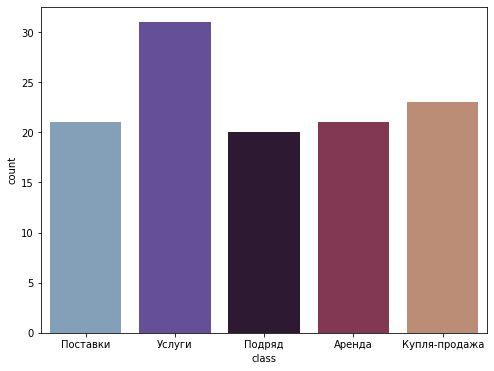

In [59]:
plt.figure(figsize=(8,6))
sns.countplot(x='class', data=data, palette='twilight')

In [73]:
def draw_word_cloud(df, doc_class):
    """Функция для отрисовки облаков слов"""
    text = ''
    for i in df[df['class']==doc_class]['lemma_text'].values:
        text += i+' '

    all_words = nltk.tokenize.word_tokenize(text.lower())
    all_words_no_stop = nltk.FreqDist(w.lower() for w in all_words if w not in russian_stopwords)

    wc = WordCloud(background_color="white", max_words=500,
                   stopwords=russian_stopwords, contour_width=4)

    wc.generate(" ".join(all_words_no_stop.keys()))

    plt.figure(figsize=(12, 8))
    plt.imshow(wc)
    plt.axis("off")
    

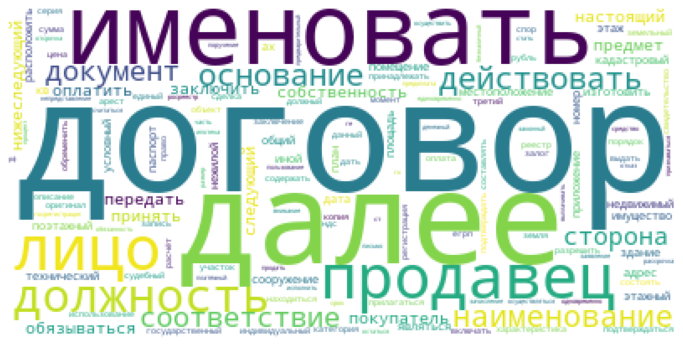

In [70]:
draw_word_cloud(data, 'Купля-продажа')

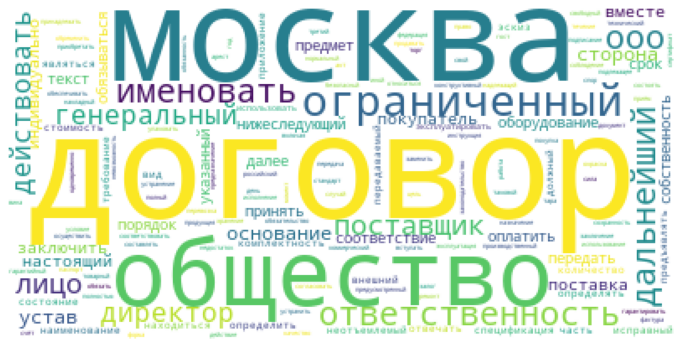

In [65]:
draw_word_cloud(data, 'Поставки')

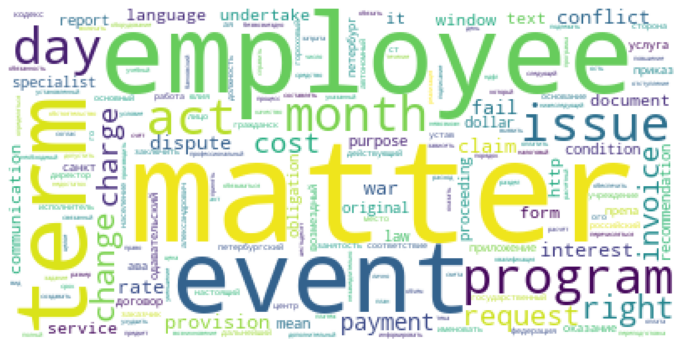

In [66]:
draw_word_cloud(data, 'Услуги')

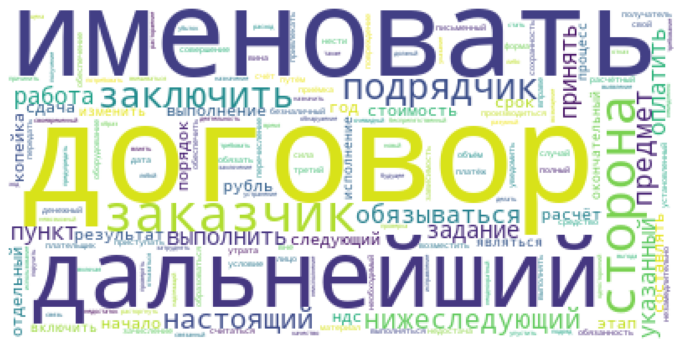

In [67]:
draw_word_cloud(data, 'Подряд')

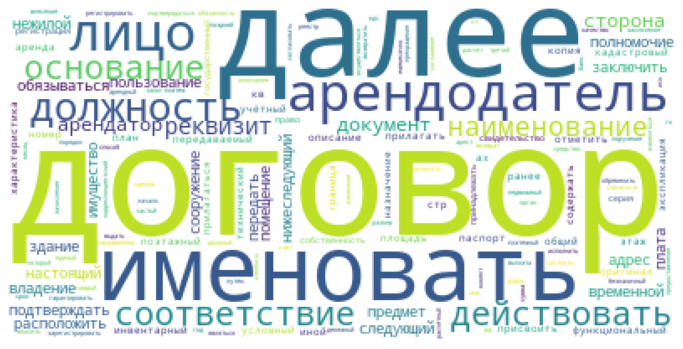

In [68]:
draw_word_cloud(data, 'Аренда')

In [315]:
########### наиболее частотные слова, встречающиеся во всех типах доков ###########

text = ''
for i in data['lemma_text'].values:
    text += i+' '

all_words = nltk.tokenize.word_tokenize(text.lower())
all_words_no_stop = nltk.FreqDist(w.lower() for w in all_words if w not in russian_stopwords)

In [317]:
all_words_no_stop.most_common(25)

[('договор', 5418),
 ('сторона', 3042),
 ('заказчик', 2050),
 ('настоящий', 1421),
 ('работа', 1417),
 ('срок', 1311),
 ('товар', 1243),
 ('исполнитель', 1240),
 ('покупатель', 1219),
 ('настоящее', 1140),
 ('услуга', 1038),
 ('случай', 1011),
 ('условие', 945),
 ('день', 924),
 ('исполнение', 793),
 ('поставщик', 764),
 ('акт', 754),
 ('подрядчик', 737),
 ('лицо', 725),
 ('обязательство', 700),
 ('порядок', 666),
 ('право', 645),
 ('который', 645),
 ('документ', 634),
 ('момент', 629)]

## 5-фолдовая кросс-валидация

In [74]:
vect = TfidfVectorizer(ngram_range=(1, 4),max_features=1000)
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=1)
pipe = make_pipeline(vect, rf)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)

In [80]:
scores = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
mean_values = []

print('Результаты классификации на 5-фолдовой кросс-валидации')
for score in scores:
    cv_score = cross_val_score(pipe, data['lemma_text'], 
                               data['class'], cv=skfold, scoring=score)
    mean_values.append(round(cv_score.mean()*100, 1))
    print('Mean {}: {}'.format(score, cv_score.mean()))
    print('StDev {}: {}'.format(score, cv_score.std()))
    print("********************************")

Результаты классификации на 5-фолдовой кросс-валидации
Mean accuracy: 0.9739130434782609
StDev accuracy: 0.052173913043478265
********************************
Mean precision_weighted: 0.9807971014492753
StDev precision_weighted: 0.03840579710144931
********************************
Mean recall_weighted: 0.9739130434782609
StDev recall_weighted: 0.052173913043478265
********************************
Mean f1_weighted: 0.9724223602484472
StDev f1_weighted: 0.055155279503105566
********************************


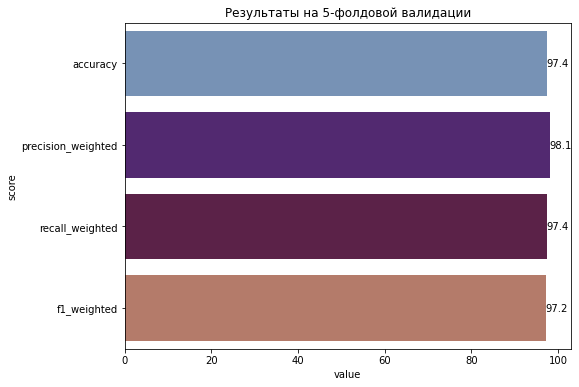

In [81]:
df_scores = pd.DataFrame({'score': scores, 'value': mean_values})
plt.figure(figsize=(8,6))
plt.title('Результаты на 5-фолдовой валидации')
ax = sns.barplot(y='score', x='value',data=df_scores, orient='h', palette='twilight')
ax.tick_params(axis='x', rotation=0)
for i in ax.containers:
    ax.bar_label(i,)
# plt.savefig('5fold.png', bbox_inches='tight')

## Бейзлайн

In [82]:
train, test = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=22)
train.shape, test.shape

((81, 7), (35, 7))

In [86]:
train['class'].value_counts()

Услуги           21
Купля-продажа    16
Аренда           15
Поставки         15
Подряд           14
Name: class, dtype: int64

In [87]:
test['class'].value_counts()

Услуги           10
Купля-продажа     7
Поставки          6
Подряд            6
Аренда            6
Name: class, dtype: int64

In [92]:
vect = TfidfVectorizer(ngram_range=(1, 4),max_features=1000)
rf = RandomForestClassifier(n_estimators=150, max_depth=15, random_state=1)
pipe = make_pipeline(vect, rf)


pipe.fit(train['lemma_text'], train['class'])
prediction = pipe.predict(test['lemma_text'])
pred_proba = pipe.predict_proba(test['lemma_text'])

In [93]:
print(classification_report(test['class'], prediction))

               precision    recall  f1-score   support

       Аренда       1.00      1.00      1.00         6
Купля-продажа       1.00      1.00      1.00         7
       Подряд       0.86      1.00      0.92         6
     Поставки       1.00      1.00      1.00         6
       Услуги       1.00      0.90      0.95        10

     accuracy                           0.97        35
    macro avg       0.97      0.98      0.97        35
 weighted avg       0.98      0.97      0.97        35



In [94]:
# pickle.dump(pipe, open('model.pkl','wb'))

In [98]:
# сохраним информацию о том, какие файлы попали в трейн/тест

train['source'] = 'train'
test['source'] = 'test'

data_tt = pd.concat([train, test])
# data.to_csv('DATA_TT.csv', index=False)

## Интерпретация с LIME 

In [222]:
test['prediction'] = prediction

In [223]:
class_names = pipe.classes_
class_names

array(['Аренда', 'Купля-продажа', 'Подряд', 'Поставки', 'Услуги'],
      dtype=object)

In [224]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=pipe.classes_)

In [225]:
# 118, 80
idx = 80

exp = explainer.explain_instance(test.loc[idx]['lemma_text'],
                                 pipe.predict_proba, num_features=6,
                                 top_labels=1)
print('Предсказанный класс:', class_names[exp.available_labels()])
print('Истинный класс: %s' % test.loc[idx]['class'])

Предсказанный класс: ['Аренда']
Истинный класс: Аренда


In [226]:
exp.show_in_notebook()

## Интерпретация с помощью ключевых фраз по каждому классу

In [99]:
data_tt['class'].unique()

array(['Подряд', 'Аренда', 'Услуги', 'Поставки', 'Купля-продажа'],
      dtype=object)

In [211]:
def compute_most_common_ngrams(text, n=200):
    all_words = nltk.tokenize.word_tokenize(text.lower())
    all_trigrams = nltk.FreqDist(nltk.trigrams(w.lower() for w in all_words))

    most_common_ngrams = []
    for k,v in dict(all_trigrams.most_common(n)).items():
        most_common_ngrams.append(' '.join(k))
    
    return most_common_ngrams


def get_keyphrases(df, doc_class):
    '''Функция для выделения ключевых фраз из корпуса.
    
    Параметры:
        df: Датасет.
        doc_class: Класс договоров, для которых необходимо выделить ключевые фразы.
    '''
    # тексты класса, для которых нужно выделить ключевые фразы
    cur_text = ''
    for i in df[df['class']==doc_class]['clean_text'].values:
        cur_text += i+' '

        
    # все тексты
    other_text = ''
    for i in df['clean_text'].values:
        other_text += i+' '
        
    cur_class_phrases = compute_most_common_ngrams(cur_text)
    commom_phrases = compute_most_common_ngrams(other_text)
    
    # отделяем фразы, которые встречаются только в договорах типа "Аренда"
    unique_phrases = set(cur_class_phrases) - set(commom_phrases)
    
    return unique_phrases

In [212]:
# Словаь ключевых фраз для каждого класса
key_phrases_dic = {}
for doc_class in data_tt['class'].unique():
    phrases = get_keyphrases(data_tt, doc_class=doc_class)
    key_phrases_dic[doc_class] = phrases

In [220]:
def predict_with_keyphrases(df, loc):
    # делаем прогноз по лемматизированным текстам, а для более понятной визуализации выводим исходный текст
    lemmatized = df['lemma_text'].iloc[loc]
    doc = df['clean_text'].iloc[loc]
    
    prediction, proba = pipe.predict([lemmatized]), pipe.predict_proba([lemmatized])
    print('Прогнозируемый тип договора: %s' %prediction[0])
    print('Прогнозная вероятность {}%'.format(round(max(proba[0])*100, 1)))
    print('')
    print('В документе встречаются следующие формулировки:')
    print('')
    for phrase in key_phrases_dic[prediction[0]]:
        if phrase in doc:
            print(phrase)
    print('**********************************************')
    print('')

In [221]:
for cl in test['class'].unique():
    print('Истинный тип договора: %s' %cl)
    predict_with_keyphrases(test[test['class']==cl], loc=0)

Истинный тип договора: Купля-продажа
Прогнозируемый тип договора: Купля-продажа
Прогнозная вероятность 66.0%

В документе встречаются следующие формулировки:

собственности на товар
расчетный счет продавца
приема передачи товара
продавец или покупатель
**********************************************

Истинный тип договора: Поставки
Прогнозируемый тип договора: Поставки
Прогнозная вероятность 79.3%

В документе встречаются следующие формулировки:

на себя обязательств
расчетного счета покупателя
потребовать от поставщика
стороны не вправе
требовать от поставщика
со стороны поставщика
покупатель вправе отказаться
случае поставки товара
покупатель вправе требовать
обычно предъявляемым требованиям
являющейся неотъемлемой частью
**********************************************

Истинный тип договора: Подряд
Прогнозируемый тип договора: Подряд
Прогнозная вероятность 66.7%

В документе встречаются следующие формулировки:

немедленно предупредить заказчика
по договору подряда
период действия дого

In [ ]:
def phrases_by_class(doc_class):
    
    # все классы
    text = ''
    for i in data['clean_text'].values:
        text += i+' '

    all_w = nltk.tokenize.word_tokenize(text.lower())
    all_w_b = nltk.FreqDist(nltk.bigrams(w.lower() for w in all_w))
    all_w_t = nltk.FreqDist(nltk.trigrams(w.lower() for w in all_w))# if w not in russian_stopwords))

    allcl = []
    for k,v in dict(all_w_t.most_common(200)).items():
        allcl.append(' '.join(k))

    
    # конкретный класс
    text = ''
    for i in data[data['class']==doc_class]['clean_text'].values:
        text += i+' '

    all_w = nltk.tokenize.word_tokenize(text.lower())
    all_w_b = nltk.FreqDist(nltk.bigrams(w.lower() for w in all_w))
    all_w_t = nltk.FreqDist(nltk.trigrams(w.lower() for w in all_w))# if w not in russian_stopwords))

    cl = []
    for k,v in dict(all_w_t.most_common(200)).items():
        cl.append(' '.join(k))
    
    diff_rent = set(cl) - set(allcl)
    return diff_rent

In [215]:
def predict_with_keyphrases(doc):
    prediction, proba = pipe.predict([doc]), pipe.predict_proba([doc])
    print('Прогнозируемый тип договора: %s' %prediction[0])
    print('Прогнозная вероятность {}%'.format(round(max(proba[0])*100, 1)))
    print('')
    print('В документе встречаются следующие формулировки:')
    print('')
    for phrase in phrases_by_class(prediction[0]):
        if phrase in doc:
            print(phrase)
    print('**********************************************')
    print('')

In [216]:
for cl in test['class'].unique():
    print('Истинный тип договора: %s' %cl)
    mydoc = test[test['class']==cl]['clean_text'].iloc[0]
    predict_with_keyphrases(mydoc)

Истинный тип договора: Купля-продажа
Прогнозируемый тип договора: Купля-продажа
Прогнозная вероятность 75.3%

В документе встречаются следующие формулировки:

известить другую сторону
покупатель обязуется принять
собственности на товар
расчетный счет продавца
**********************************************

Истинный тип договора: Поставки
Прогнозируемый тип договора: Поставки
Прогнозная вероятность 44.7%

В документе встречаются следующие формулировки:

потребовать от поставщика
требовать от поставщика
неотъемлемой частью договора
полного исполнения сторонами
расчетный счет поставщика
течение гарантийного срока
**********************************************

Истинный тип договора: Подряд
Прогнозируемый тип договора: Купля-продажа
Прогнозная вероятность 27.3%

В документе встречаются следующие формулировки:

этом другую сторону
вправе по своему
кодекса российской федерации
соответствии со ст
по своему выбору
об этом другую
или отказаться от
**********************************************


## Наличие в тексте кодексов РФ

In [153]:
legal_codes = {'ГК РФ': 'Гражданский кодекс РФ',
          'ТК РФ': 'Трудовой кодекс РФ',
         'НК РФ': 'Налоговый кодекс РФ',
         'КоАП РФ': 'Кодекс об административных правонарушениях РФ',
         'УК РФ': 'Уголовный кодекс РФ',
         'ГПК РФ': 'Гражданский процессуальный кодекс РФ',
         'АПК РФ':'Арбитражный процессуальный кодекс РФ',
         'ЖК РФ': 'Жилищный кодекс РФ',
         'СК РФ': 'Семейный кодекс РФ'}

In [154]:
def check_for_legal_codes(doc):
    found_codes = []
    for k, v in legal_codes.items():
        if k.lower() in doc:
            found_codes.append(v)
    
    return found_codes

In [170]:
print(data.iloc[2]['class'])
check_for_legal_codes(data.iloc[2]['clean_text'])

Поставки


['Гражданский кодекс РФ', 'Налоговый кодекс РФ']

## Оценка уникальности договора.
- Лемматизация текста
- На 70% документов (train): создание множества употребляемых униграмм для каждого класса.
- На 30% документов (test): подсчет процента слов в тексте, не входящих во множество слов этого класса, определенного на трейн выборке.

In [503]:
def create_lexica(fn):
    data = pd.read_csv(fn)
    
    lexica_dic = {}
    for cl in data['class'].unique():
        cur_df = data[(data['source']=='train') & (data['class']==cl)]
        
        lexicon = set()
        for text in cur_df['lemma_text']:
            lexicon.update(set(text.split()))
        lexica_dic[cl] = lexicon
    return lexica_dic

In [504]:
# LEXICA = create_lexica('DATA_TT.csv')

In [533]:
def check_typicality(doc, doc_class):
    '''Наилучший результат достигается при использовании лемматизированных текстов'''
    tokenized = set(doc.split())
    uniq_percent = round(len(tokenized - LEXICA[doc_class])/len(tokenized) * 100, 1)
    
    if uniq_percent < 30:
        print('Уникальность текста составяет {}%. Типовой документ для класса "{}"'.format(uniq_percent, doc_class))
    else:
        print('Внимание! Уникальность - {}%. Высокая вероятность нетипичных условий.'.format(uniq_percent))
    

In [536]:
to_check = test[test['class']=='Купля-продажа'].iloc[1]['lemma_text']
check_typicality(to_check, 'Купля-продажа')

Внимание! Уникальность - 32.7%. Высокая вероятность нетипичных условий.
